# 02. PyTorch Neural Network Classification

In [1]:
# from IPython.core.interactiveshell import InteractiveShell

# InteractiveShell.ast_node_interactivity = "all"

In [2]:
from sklearn.datasets import make_circles

In [3]:
SEED = 42
n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=SEED)

In [4]:
X.shape, y.shape

((1000, 2), (1000,))

In [5]:
X[:5]
y[:5]

array([1, 1, 1, 1, 0])

In [6]:
import pandas as pd

In [7]:
circles = pd.DataFrame(
    {
        "X1": X[:, 0],
        "X2": X[:, 1],
        "label": y,
    },
)

In [8]:
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [9]:
circles["label"].value_counts()

label
1    500
0    500
Name: count, dtype: int64

## Visualize

In [10]:
import matplotlib.pyplot as plt

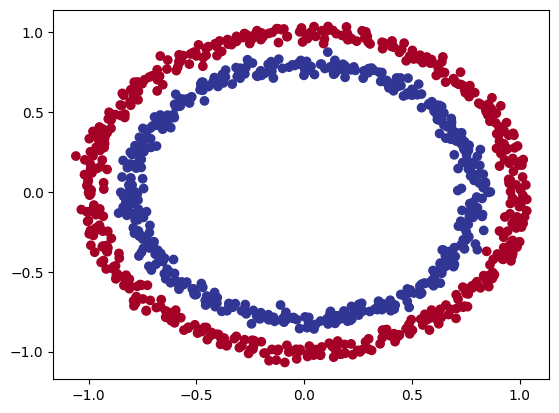

In [11]:
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [12]:
import torch

In [13]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [14]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [15]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [16]:
type(X), X.dtype, type(y), y.dtype

(torch.Tensor, torch.float32, torch.Tensor, torch.float32)

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

In [18]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## Building a model

In [19]:
import torch
import torch.nn as nn

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [21]:
X_train.shape

torch.Size([800, 2])

In [22]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=1)
        self.layer_2 = nn.Linear(in_features=5, out_features=2)
        # self.two_linear_layers = nn.Sequential(
        #     nn.Linear(in_features=2, out_features=5),
        #     nn.Linear(in_features=5, out_features=1)
        # )

    def forward(self, x):
        return self.layer_2(self.layer_1(x))
        # return self.two_linear_layers(x)

In [23]:
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=1, bias=True)
  (layer_2): Linear(in_features=5, out_features=2, bias=True)
)

In [24]:
def view_model_device(model):
    model_device = next(model.parameters()).device
    print(f"model is on: {model_device}")
    return model_device

In [25]:
view_model_device(model_0)

model is on: cuda:0


device(type='cuda', index=0)

In [26]:
feat_n = 5
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=feat_n),
    nn.Linear(in_features=feat_n, out_features=1),
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [27]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.4533, -0.2158],
                      [ 0.5000,  0.3085],
                      [-0.3367,  0.6367],
                      [-0.1539, -0.4428],
                      [ 0.5253, -0.2173]], device='cuda:0')),
             ('0.bias',
              tensor([-0.0945, -0.0661, -0.7044,  0.1580, -0.2553], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.4109,  0.2460,  0.2722, -0.1213,  0.4272]], device='cuda:0')),
             ('1.bias', tensor([0.0105], device='cuda:0'))])

In [28]:
model_0.eval()
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.3148],
        [-0.2466],
        [-0.4648],
        [-0.2724],
        [-0.4193],
        [-0.3780],
        [-0.2222],
        [-0.2529],
        [-0.4664],
        [-0.2416]], device='cuda:0')

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [29]:
# loss_func = nn.Sequential(
#     nn.Sigmoid(),
#     nn.BCELoss()
# )

loss_func = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

## Calculate Accuracy

In [30]:
def accuracy_func(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [31]:
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]

y_logits

tensor([[-0.3148],
        [-0.2466],
        [-0.4648],
        [-0.2724],
        [-0.4193]], device='cuda:0')

In [32]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4219],
        [0.4387],
        [0.3859],
        [0.4323],
        [0.3967]], device='cuda:0')

In [33]:
y_preds = torch.round(y_pred_probs)
y_preds

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')

In [34]:
y_preds_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))
print(torch.eq(y_preds.squeeze(), y_preds_labels.squeeze()))

y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 0.], device='cuda:0')

## Training Loop

In [35]:
!nvidia-smi

Sun May 21 18:38:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 33%   51C    P2    30W / 120W |   2226MiB /  6144MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [36]:
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_0.train()

    # 1. forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Cal Loss / Acc
    # train_loss = loss_func(torch.sigmoid(y_logits), y_train)  # nn.BCELoss expects prediction probs as input

    train_loss = loss_func(y_logits, y_train)
    train_acc = accuracy_func(y_train, y_pred)

    optimizer.zero_grad()

    train_loss.backward()

    optimizer.step()

    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_func(test_logits, y_test)

        test_acc = accuracy_func(y_true=y_test, y_pred=test_pred)

    if epoch % 10 == 0:
        print(
            f"Epoch: {epoch} | Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%"
        )

Epoch: 0 | Train Loss: 0.71011, Train Acc: 50.00% | Test Loss: 0.71180, Test Acc: 50.00%
Epoch: 10 | Train Loss: 0.69902, Train Acc: 50.00% | Test Loss: 0.70131, Test Acc: 50.00%
Epoch: 20 | Train Loss: 0.69526, Train Acc: 50.00% | Test Loss: 0.69749, Test Acc: 50.00%
Epoch: 30 | Train Loss: 0.69392, Train Acc: 42.50% | Test Loss: 0.69598, Test Acc: 39.50%
Epoch: 40 | Train Loss: 0.69342, Train Acc: 46.00% | Test Loss: 0.69534, Test Acc: 48.00%
Epoch: 50 | Train Loss: 0.69321, Train Acc: 47.75% | Test Loss: 0.69503, Test Acc: 48.00%
Epoch: 60 | Train Loss: 0.69312, Train Acc: 48.88% | Test Loss: 0.69488, Test Acc: 48.50%
Epoch: 70 | Train Loss: 0.69308, Train Acc: 49.88% | Test Loss: 0.69479, Test Acc: 49.00%
Epoch: 80 | Train Loss: 0.69305, Train Acc: 50.12% | Test Loss: 0.69473, Test Acc: 48.00%
Epoch: 90 | Train Loss: 0.69303, Train Acc: 50.25% | Test Loss: 0.69470, Test Acc: 48.00%


## make predictions and evaluate the model

In [37]:
from pathlib import Path

import requests

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get(
        "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py"
    )
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_decision_boundary, plot_predictions

helper_functions.py already exists, skipping download


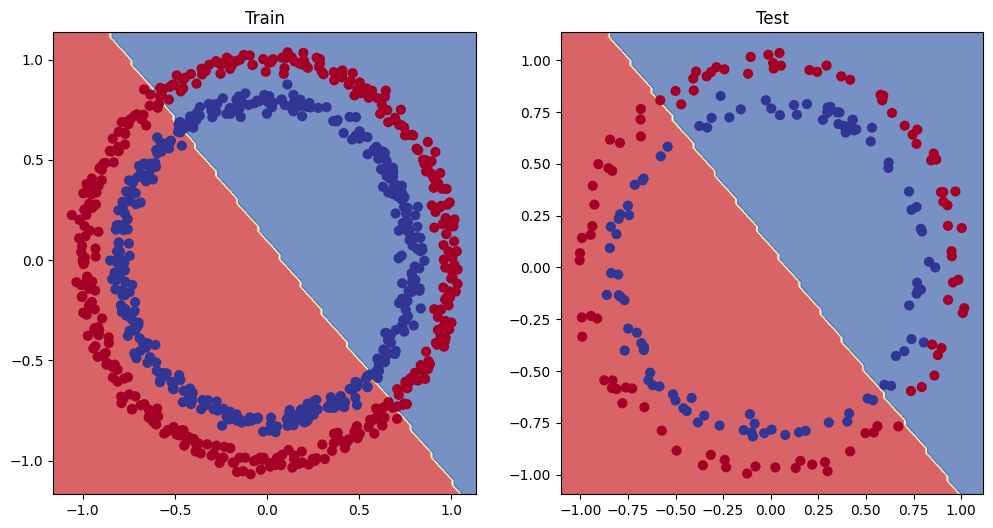

In [38]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## improving model

In [39]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)

        return self.layer_3(self.layer_2(self.layer_1(x)))

In [40]:
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [41]:
loss_func = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [42]:
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_1.train()

    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    train_loss = loss_func(y_logits, y_train)
    train_acc = accuracy_func(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()

    train_loss.backward()

    optimizer.step()

    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_func(test_logits, y_test)
        test_acc = accuracy_func(y_true=y_test, y_pred=test_pred)

    if epoch % 100 == 0:
        print(
            f"Epoch: {epoch} | Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%"
        )

Epoch: 0 | Train Loss: 0.69396, Train Acc: 50.88% | Test Loss: 0.69261, Test Acc: 51.00%
Epoch: 100 | Train Loss: 0.69305, Train Acc: 50.38% | Test Loss: 0.69379, Test Acc: 48.00%
Epoch: 200 | Train Loss: 0.69299, Train Acc: 51.12% | Test Loss: 0.69437, Test Acc: 46.00%
Epoch: 300 | Train Loss: 0.69298, Train Acc: 51.62% | Test Loss: 0.69458, Test Acc: 45.00%
Epoch: 400 | Train Loss: 0.69298, Train Acc: 51.12% | Test Loss: 0.69465, Test Acc: 46.00%
Epoch: 500 | Train Loss: 0.69298, Train Acc: 51.00% | Test Loss: 0.69467, Test Acc: 46.00%
Epoch: 600 | Train Loss: 0.69298, Train Acc: 51.00% | Test Loss: 0.69468, Test Acc: 46.00%
Epoch: 700 | Train Loss: 0.69298, Train Acc: 51.00% | Test Loss: 0.69468, Test Acc: 46.00%
Epoch: 800 | Train Loss: 0.69298, Train Acc: 51.00% | Test Loss: 0.69468, Test Acc: 46.00%
Epoch: 900 | Train Loss: 0.69298, Train Acc: 51.00% | Test Loss: 0.69468, Test Acc: 46.00%


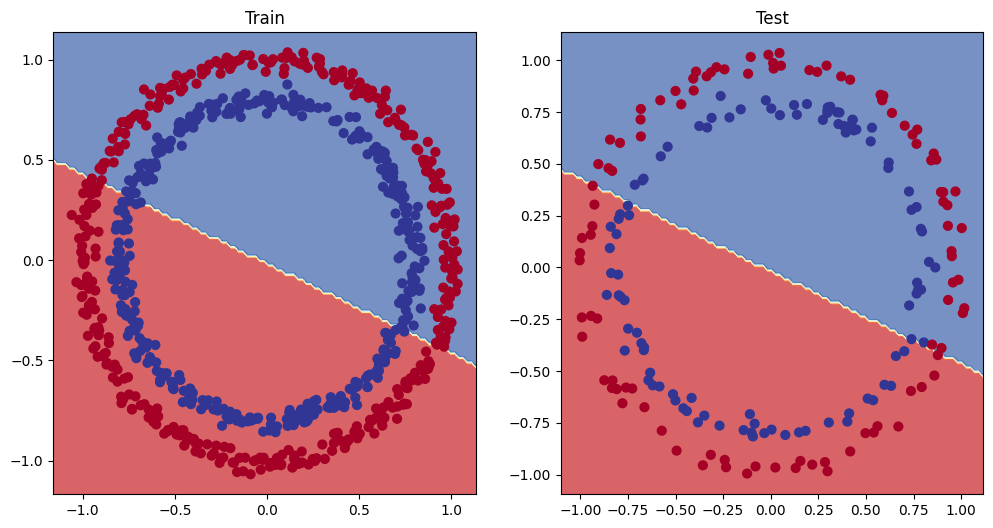

In [43]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

In [44]:
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [45]:
# Create train and test splits
train_split = int(0.8 * len(X_regression))  # 80% of data used for training set
X_train_regression, y_train_regression = (
    X_regression[:train_split],
    y_regression[:train_split],
)
X_test_regression, y_test_regression = (
    X_regression[train_split:],
    y_regression[train_split:],
)

# Check the lengths of each split
print(
    len(X_train_regression),
    len(y_train_regression),
    len(X_test_regression),
    len(y_test_regression),
)

80 80 20 20


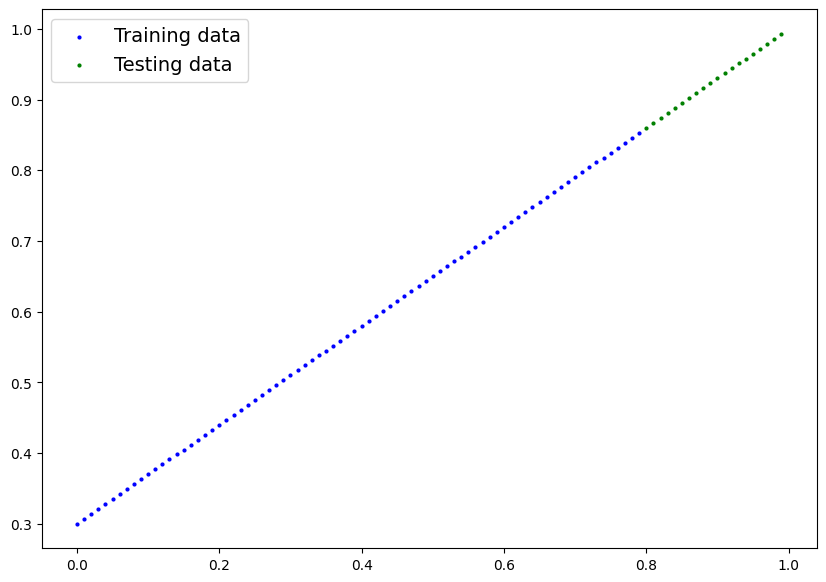

In [46]:
plot_predictions(
    train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression,
)

In [47]:
# Same architecture as model_1 (but using nn.Sequential())
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1),
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [48]:
# Loss and optimizer
loss_func = nn.L1Loss()  # MAE loss with regression data
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.01)

In [49]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put the data on the target device
X_train_regression, y_train_regression = X_train_regression.to(
    device
), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(
    device
), y_test_regression.to(device)

# Training
for epoch in range(epochs):
    y_pred = model_2(X_train_regression)
    loss = loss_func(y_pred, y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Testing
    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_func(test_pred, y_test_regression)

    # Print out what's happenin'
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.75986 | Test loss: 0.91103
Epoch: 100 | Loss: 0.02858 | Test loss: 0.00081
Epoch: 200 | Loss: 0.02533 | Test loss: 0.00209
Epoch: 300 | Loss: 0.02137 | Test loss: 0.00305
Epoch: 400 | Loss: 0.01964 | Test loss: 0.00341
Epoch: 500 | Loss: 0.01940 | Test loss: 0.00387
Epoch: 600 | Loss: 0.01903 | Test loss: 0.00379
Epoch: 700 | Loss: 0.01878 | Test loss: 0.00381
Epoch: 800 | Loss: 0.01840 | Test loss: 0.00329
Epoch: 900 | Loss: 0.01798 | Test loss: 0.00360


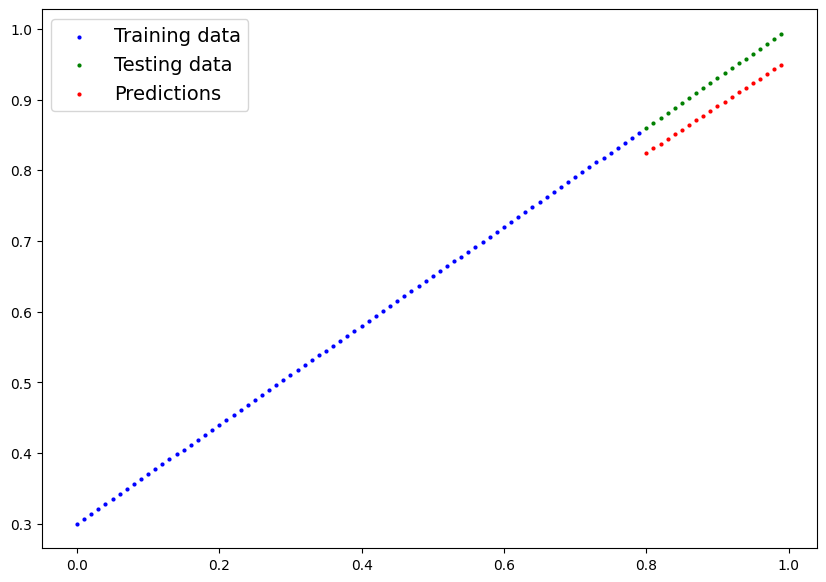

In [50]:
model_2.eval()
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

plot_predictions(
    train_data=X_train_regression.cpu(),
    train_labels=y_train_regression.cpu(),
    test_data=X_test_regression.cpu(),
    test_labels=y_test_regression.cpu(),
    predictions=y_preds.cpu()
)

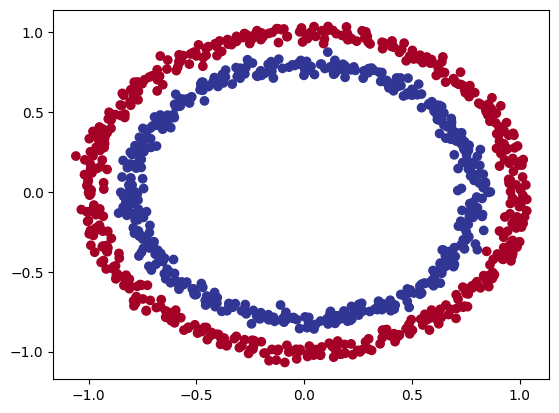

In [84]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=SEED,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [85]:
# Convert data to tensors and then to train and test splits 
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float) 
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=SEED)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

## Build mode with non-linear activation function

In [86]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In [87]:
model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [88]:
loss_func = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.3)

In [89]:
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

for epoch in range(epochs):
    model_3.train()

    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    train_loss = loss_func(y_logits, y_train)
    train_acc = accuracy_func(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()

    train_loss.backward()

    optimizer.step()

    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_func(test_logits, y_test)
        test_acc = accuracy_func(y_true=y_test, y_pred=test_pred)

    if epoch % 100 == 0:
        print(
            f"Epoch: {epoch} | Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%"
        )

torch.Size([800, 2]) torch.Size([800]) torch.Size([200, 2]) torch.Size([200])
Epoch: 0 | Train Loss: 0.69295, Train Acc: 50.00% | Test Loss: 0.69306, Test Acc: 50.00%
Epoch: 100 | Train Loss: 0.68796, Train Acc: 53.00% | Test Loss: 0.68720, Test Acc: 56.00%
Epoch: 200 | Train Loss: 0.67525, Train Acc: 54.37% | Test Loss: 0.67280, Test Acc: 56.50%
Epoch: 300 | Train Loss: 0.62461, Train Acc: 73.75% | Test Loss: 0.62162, Test Acc: 78.50%
Epoch: 400 | Train Loss: 0.37448, Train Acc: 97.75% | Test Loss: 0.40727, Test Acc: 93.00%
Epoch: 500 | Train Loss: 0.36851, Train Acc: 79.88% | Test Loss: 0.40743, Test Acc: 72.50%
Epoch: 600 | Train Loss: 0.08139, Train Acc: 100.00% | Test Loss: 0.11955, Test Acc: 97.50%
Epoch: 700 | Train Loss: 0.04110, Train Acc: 100.00% | Test Loss: 0.06989, Test Acc: 99.00%
Epoch: 800 | Train Loss: 0.02679, Train Acc: 100.00% | Test Loss: 0.04929, Test Acc: 99.00%
Epoch: 900 | Train Loss: 0.01982, Train Acc: 100.00% | Test Loss: 0.04010, Test Acc: 99.50%


## Evaluating non-linear model

In [90]:
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

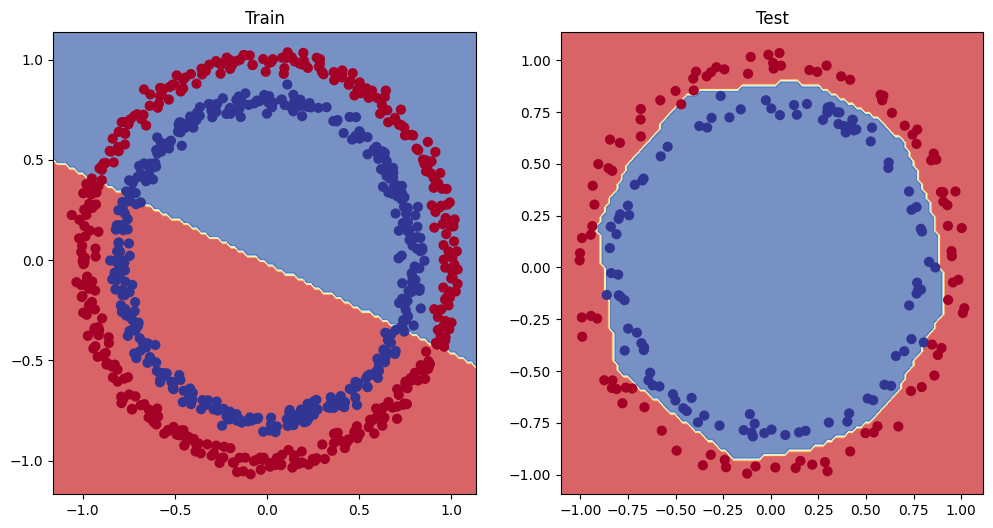

In [91]:
# Plot decision boundaries
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

## Replicating non-linear activation functions

In [96]:
A = torch.arange(-10, 10, 0.1, dtype=torch.float32)
A.dtype

torch.float32

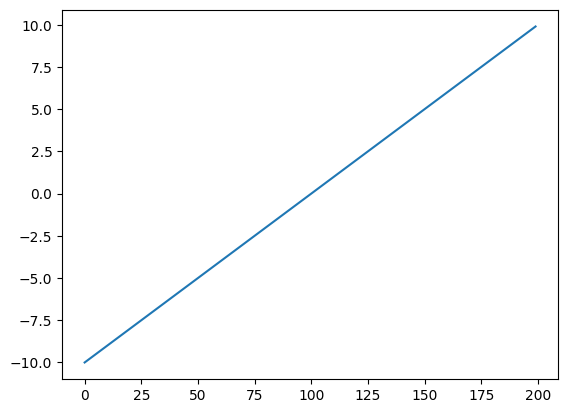

In [97]:
plt.plot(A)

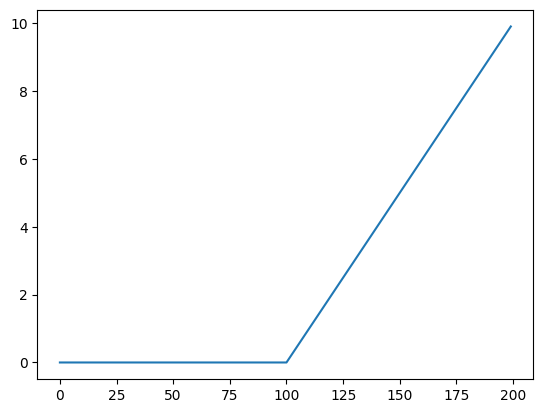

In [99]:
plt.plot(torch.relu(A))

In [104]:
def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0), x)

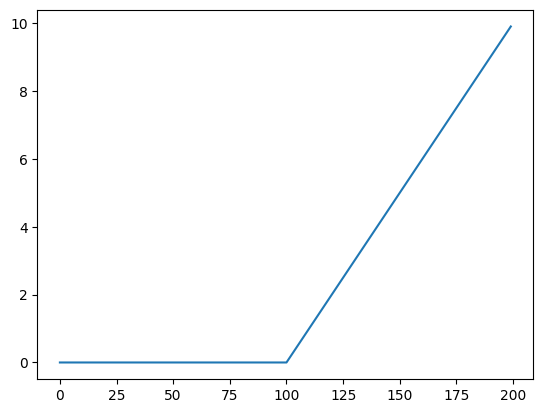

In [106]:
plt.plot(relu(A))

In [107]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

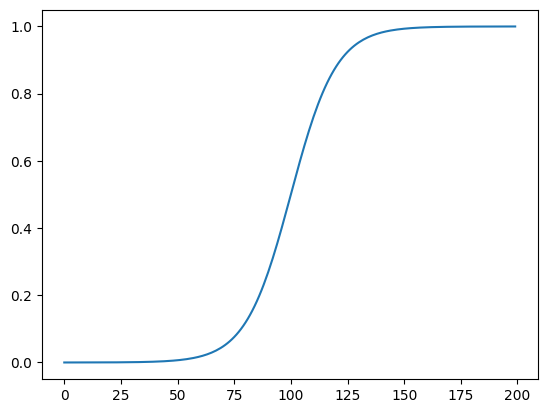

In [108]:
plt.plot(sigmoid(A))